In [2]:
import numpy as np
import scipy.optimize as sopt
import matplotlib.pyplot as plt
import pydae.ssa as ssa
import pydae.grid_tools as gt
from pydae.tools import get_i
import json
import time
import scipy.optimize as sopt
import pandas as pd
 

In [3]:
from cigre_europe_residential_4w2w import cigre_europe_residential_4w2w_class

In [4]:
def get_bus_powers(gt_grid,bus_name):
    idx = gt_grid.bus_data['bus_id'].index(bus_name)
    p_a,q_a = gt_grid.buses[idx]['p_a'],gt_grid.buses[idx]['p_a']
    p_b,q_b = gt_grid.buses[idx]['p_b'],gt_grid.buses[idx]['q_b']
    p_c,q_c = gt_grid.buses[idx]['p_c'],gt_grid.buses[idx]['q_c']
    p = p_a + p_b + p_c
    q = q_a + q_b + q_c
    return p,q

def vsc2params(vsc_losses,name,multiplier=1):
    i_rms  = np.array(vsc_losses[name]['i_rms'])
    p_loss = np.array(vsc_losses[name]['p_loss']) 
    c,b,a = np.polyfit(i_rms, p_loss*multiplier,2)
    return a,b,c

def report(grid, gt_grid):
    p_R0,q_R0 = get_bus_powers(gt_grid,'R0')
    p_R1,q_R1 = get_bus_powers(gt_grid,'R1')
    p_D1,q_D1 = get_bus_powers(gt_grid,'D1')
    p_R10,q_R10 = get_bus_powers(gt_grid,'R10')
    p_D10,q_D10 = get_bus_powers(gt_grid,'D10')
    p_R14,q_R14 = get_bus_powers(gt_grid,'R14')
    p_D14,q_D14 = get_bus_powers(gt_grid,'D14')

    p_R1_load = (loads_ac[0]['kVA']*np.exp(1j*np.arccos( loads_ac[0]['pf']))*1000).real

    p_main_vsc_ac = -(p_R1 - p_R1_load)

    p_dc_losses = p_main_vsc_ac - grid.p_dc_loads

    p_losses = p_R0 + grid.p_ac_loads + grid.p_dc_loads
    grid.p_losses = p_losses
    print(f'Grid power = {p_R0/1e3:0.2f} kW')
    print(f'AC loads   = {-grid.p_ac_loads/1e3:0.2f} kW')
    print(f'DC loads   = {-grid.p_dc_loads/1e3:0.2f} kW')
    print(f'Total load = {-(grid.p_ac_loads+grid.p_dc_loads)/1e3:0.2f} kW')
    p_loss_R1  = -(p_R1+p_D1-p_R1_load)
    p_loss_R10 = -(p_R10+p_D10)
    p_loss_R14 = -(p_R14+p_D14)
    print(f'VSC Losses: R1 = {p_loss_R1:0.2f} W ({-p_loss_R1/p_R1*100:0.1f}%),  R10 = {p_loss_R10:0.2f} W ({p_loss_R10/p_R10*100:0.1f}%),  R14 = {p_loss_R14:0.2f} W ({p_loss_R14/p_R14*100:0.1f}%)')

    idx = [(item['bus_j'],item['bus_k']) for item in gt_grid.lines].index(('R1', 'R2'))
    i_j_a_m = gt_grid.lines[idx]['i_j_a_m']
    print(f'Current R1-R2 ={i_j_a_m:0.2f} A')
    idx = [(item['bus_j'],item['bus_k']) for item in gt_grid.lines].index(('R4', 'R12'))
    i_j_a_m = gt_grid.lines[idx]['i_j_a_m']
    print(f'Current R4-R12 ={i_j_a_m:0.2f} A')
    idx = [(item['bus_j'],item['bus_k']) for item in gt_grid.lines].index(('D1', 'D3'))
    i_j_a_m = gt_grid.lines[idx]['i_j_a_m']
    print(f'Current D1-D3 ={i_j_a_m:0.2f} A')
    idx = [(item['bus_j'],item['bus_k']) for item in gt_grid.lines].index(('D4', 'D14'))
    i_j_a_m = gt_grid.lines[idx]['i_j_a_m']
    print(f'Current D4-R14 ={i_j_a_m:0.2f} A')


### VSC models

In [5]:
vsc_losses = {
    'vsc_3ph3w_200A_100kVA':{'model':'','coolant':'air','v_dc':800,
                            'i_rms':[50,100,200],'p_loss':[404.9,871.61,2090.05],'rend':[98.6,98.54,98.26]},
    'vsc_3ph3w_250A_200kVA':{'model':'SKiiP1213GB123-2DW V3','coolant':'water','Rth_sa': 0.0114,'v_dc':800,
                            'i_rms':[125,250,500],'p_loss':[1210.95,2610.23,6229.22],'rend':[98.38,98.26,97.93]}, 
    'vsc_1ph2w_120A':{'model':'SKiiP39AC12T7V1_HpTp','coolant':'air','v_dc':800,'pf':0.85,'Rth_sa': 0.0707,
                         'i_rms':[20,40,60,80,100,120],
                         'p_loss':[96.91,205.54,322.16,455.22,609.84,795.07],
                         'rend':[97.59,97.45,97.34,97.18,96.99,96.74]}
}

## Case 0

In [6]:
loads_ac =[{"bus":  "R1", "kVA":-200.0, "pf": 0.95},
           {"bus": "R11", "kVA": -15.0, "pf": 0.95},
           {"bus": "R15", "kVA": -52.0, "pf": 0.95},
           {"bus": "R16", "kVA": -55.0, "pf": 0.95},
           {"bus": "R17", "kVA": -35.0, "pf": 0.95},
           {"bus": "R18", "kVA": -47.0, "pf": 0.95}]

loads_dc =[{"bus": "D11", "kW": 0.0},
           {"bus": "D15", "kW": 0.0},
           {"bus": "D16", "kW": 0.0},
           {"bus": "D17", "kW": 0.0},
           {"bus": "D18", "kW": 0.0}]

vscs =[{"bus":  "R10", "kW":0.0, "kvar": 0.0},
        {"bus": "R14", "kW":0.0, "kvar": 0.0}]

In [7]:
grid_c0 = cigre_europe_residential_4w2w_class()
grid_c0.initialization_tol = 1e-12

grid_c0.p_ac_loads = 0.0
for load in loads_ac:
    bus_name = load['bus']
    s = load['kVA']*np.exp(1j*np.arccos( load['pf']))*1000
    gt.set_powers(grid_c0,bus_name,s)
    grid_c0.p_ac_loads += s.real

grid_c0.p_dc_loads = 0.0
for load in loads_dc:
    bus_name = load['bus']
    grid_c0.set_value(f'p_{bus_name}_1',load['kW']*1000.0)
    grid_c0.set_value(f'q_{bus_name}_1',0.0)
    
for vsc in vscs:
    bus_name = vsc['bus']
    s = vsc['kW'] + 1j*vsc['kvar']
    grid_c0.set_value(f'p_{bus_name}',vsc['kW']*1000.0)
    grid_c0.set_value(f'q_{bus_name}',vsc['kvar']*1000.0)


grid_c0.load_0('xy_0_dict.json')
grid_c0.ss()
gt_grid = gt.grid(grid_c0)


In [8]:
gt_grid = gt.grid(grid_c0)
gt_grid.dae2vi()

gt_grid.get_v()
gt_grid.get_i()

gt_grid.bokeh_tools()

gt.plot_results(gt_grid)

Figure(id='1002', ...)

In [14]:
def s_eval(grid,bus_j,bus_k):
    line_id = f'{bus_j}_{bus_k}'
    i_t_r = np.array(grid.get_mvalue([f'i_t_{line_id}_a_r',f'i_t_{line_id}_b_r',f'i_t_{line_id}_c_r']))
    i_t_i = np.array(grid.get_mvalue([f'i_t_{line_id}_a_i',f'i_t_{line_id}_b_i',f'i_t_{line_id}_c_i']))
    i_t = i_t_r + 1j*i_t_i
    v_r = np.array(grid.get_mvalue([f'v_{bus_j}_a_r',f'v_{bus_j}_b_r',f'v_{bus_j}_c_r']))
    v_i = np.array(grid.get_mvalue([f'v_{bus_j}_a_i',f'v_{bus_j}_b_i',f'v_{bus_j}_c_i']))
    v = v_r + 1j*v_i
    
    s = v.T @ np.conj(i_t)
    return s


In [15]:
grid = grid_c0
grid.initialization_tol = 1e-8
def obj_eval(x):

    grid.set_values({'p_R10':x[0],'q_R10':x[1]})
    grid.set_values({'p_R14':x[2],'q_R14':x[3]})
    grid.ss()
    s_t = s_eval(grid,'R0','R1')
    p_loss = float(s_t.real+grid.p_ac_loads+grid.p_dc_loads)
    #print(f'p_loss = {p_loss/1e3:0.2f}')

    return p_loss



In [17]:
sol = sopt.minimize(obj_eval,[10e3]*4,method='Powell',bounds=[(-50e3,50e3)]*4) # SLSQP, Powell
sol

   direc: array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])
     fun: array(8776.88248027)
 message: 'Optimization terminated successfully.'
    nfev: 284
     nit: 3
  status: 0
 success: True
       x: array([47713.77072184, 34234.54298113, 40501.45414448, 19707.59483937])

In [18]:
sopt.differential_evolution(obj_eval, bounds=[(-50e3,50e3)]*4, tol=1e-10)

     fun: 8776.882111125742
     jac: array([-3.81950509,  4.45997089,  7.01018923, -1.28628592])
 message: 'Optimization terminated successfully.'
    nfev: 3440
     nit: 55
 success: True
       x: array([47691.60579656, 34224.10348511, 40507.35972341, 19709.56517666])

In [31]:
sopt.dual_annealing(obj_eval, bounds=[(-50e3,50e3)]*4)


     fun: 8776.882111013168
 message: ['Maximum number of iteration reached']
    nfev: 13306
    nhev: 0
     nit: 1000
    njev: 1061
  status: 0
 success: True
       x: array([47691.68178532, 34223.89092615, 40507.44174223, 19709.66952102])

In [ ]:
sopt.dual_annealing(obj_eval, bounds=[(-50e3,50e3)]*4)


In [26]:
gt_grid = gt.grid(grid)
gt_grid.dae2vi()

gt_grid.get_v()
gt_grid.get_i()

gt_grid.bokeh_tools()

gt.plot_results(gt_grid)

i_r_name = i_load_R1_a_r
i_r_name = i_load_R1_b_r
i_r_name = i_load_R1_c_r
i_r_name = i_load_R1_n_r
i_r_name = i_load_R11_a_r
i_r_name = i_load_R11_b_r
i_r_name = i_load_R11_c_r
i_r_name = i_load_R11_n_r
i_r_name = i_load_R15_a_r
i_r_name = i_load_R15_b_r
i_r_name = i_load_R15_c_r
i_r_name = i_load_R15_n_r
i_r_name = i_load_R16_a_r
i_r_name = i_load_R16_b_r
i_r_name = i_load_R16_c_r
i_r_name = i_load_R16_n_r
i_r_name = i_load_R17_a_r
i_r_name = i_load_R17_b_r
i_r_name = i_load_R17_c_r
i_r_name = i_load_R17_n_r
i_r_name = i_load_R18_a_r
i_r_name = i_load_R18_b_r
i_r_name = i_load_R18_c_r
i_r_name = i_load_R18_n_r
i_r_name = i_load_D15_a_r
i_r_name = i_load_D15_n_r
i_r_name = i_load_D11_a_r
i_r_name = i_load_D11_n_r
i_r_name = i_load_D16_a_r
i_r_name = i_load_D16_n_r
i_r_name = i_load_D17_a_r
i_r_name = i_load_D17_n_r
i_r_name = i_load_D18_a_r
i_r_name = i_load_D18_n_r
i_r_name = i_vsc_R1_a_r
i_r_name = i_vsc_R1_b_r
i_r_name = i_vsc_R1_c_r
i_r_name = i_vsc_R10_a_r
i_r_name = i_vsc_R10_b_

Figure(id='1300', ...)

## Case 1

In [9]:
scale = 1.5
loads_ac =[{"bus":  "R1", "kVA":-200.0, "pf": 0.95},
           {"bus": "R11", "kVA": -15.0*scale, "pf": 0.95},
           {"bus": "R15", "kVA": -52.0*scale, "pf": 0.95},
           {"bus": "R16", "kVA": -55.0*scale, "pf": 0.95},
           {"bus": "R17", "kVA": -35.0*scale, "pf": 0.95},
           {"bus": "R18", "kVA": -47.0*scale, "pf": 0.95}]

loads_dc =[{"bus": "D11", "kW": 0.0},
           {"bus": "D15", "kW": 0.0},
           {"bus": "D16", "kW": 0.0},
           {"bus": "D17", "kW": 0.0},
           {"bus": "D18", "kW": 0.0}]

vscs =[{"bus":  "R10", "kW":0.0, "kvar": 0.0},
        {"bus": "R14", "kW":0.0, "kvar": 0.0}]

In [10]:
grid_c1 = cigre_europe_residential_acdc_class()
grid_c1.initialization_tol = 1e-8

for load in loads_ac:
    bus_name = load['bus']
    s = load['kVA']*np.exp(1j*np.arccos( load['pf']))*1000
    gt.set_powers(grid_c1,bus_name,s)

for load in loads_dc:
    bus_name = load['bus']
    grid_c1.set_value(f'p_{bus_name}_1',load['kW']*1000.0)
    grid_c1.set_value(f'q_{bus_name}_1',0.0)
    
for vsc in vscs:
    bus_name = load['bus']
    s = vsc['kW'] + 1j*vsc['kvar']
    grid_c1.set_value(f'p_{bus_name}',vsc['kW']*1000.0)
    grid_c1.set_value(f'q_{bus_name}',vsc['kvar']*1000.0)


grid_c1.initialize([{}],xy0='xy_0_dict.json',compile=True)
gt_grid = gt.grid(grid_c1)


NameError: name 'cigre_europe_residential_acdc_class' is not defined

In [11]:
gt_grid.dae2vi()

vsc_buses = ['R1','R10','R14']
a2n = {'a':1,'b':2,'c':3}
for vsc_bus in vsc_buses:
    for ph in ['a','b','c']:
        idx = list(gt_grid.nodes_list).index(f'{vsc_bus}.{a2n[ph]}') 
        gt_grid.I_node[idx] += grid_c1.get_value(f'i_vsc_{vsc_bus}_{ph}_r')+1j*grid_c1.get_value(f'i_vsc_{vsc_bus}_{ph}_i')

gt_grid.get_v()
gt_grid.get_i()

gt_grid.bokeh_tools()

gt.plot_results(gt_grid)

NameError: name 'grid_c1' is not defined

## Case 2

In [12]:
scale_ac = 1.0
scale_dc = 0.5

loads_ac =[{"bus":  "R1", "kVA":-00.0, "pf": 0.95},
           {"bus": "R11", "kVA": -15.0*scale_ac, "pf": 0.95},
           {"bus": "R15", "kVA": -52.0*scale_ac, "pf": 0.95},
           {"bus": "R16", "kVA": -55.0*scale_ac, "pf": 0.95},
           {"bus": "R17", "kVA": -35.0*scale_ac, "pf": 0.95},
           {"bus": "R18", "kVA": -47.0*scale_ac, "pf": 0.95}]

loads_dc =[{"bus": "D11", "kW": -15.0*scale_dc},
           {"bus": "D15", "kW": -52.0*scale_dc},
           {"bus": "D16", "kW": -55.0*scale_dc},
           {"bus": "D17", "kW": -35.0*scale_dc},
           {"bus": "D18", "kW": -47.0*scale_dc}]

vscs =[{"bus": "R1", "type":'vdc',"kW":0.0, "kvar": 0.0,'losses':vsc2params(vsc_losses,'vsc_3ph3w_250A_200kVA')},
       {"bus": "R10","type":'pq', "kW":10.0, "kvar": 0.0,'losses':vsc2params(vsc_losses,'vsc_3ph3w_250A_200kVA')},
       {"bus": "R14","type":'pq', "kW":10.0, "kvar": 0.0,'losses':vsc2params(vsc_losses,'vsc_3ph3w_250A_200kVA')}
      ]


In [13]:
grid_c2 = cigre_europe_residential_acdc_4ac_class()
grid_c2.initialization_tol = 1e-8

grid_c2.p_ac_loads = 0.0
for load in loads_ac:
    bus_name = load['bus']
    s = load['kVA']*np.exp(1j*np.arccos( load['pf']))*1000
    gt.set_powers(grid_c2,bus_name,s)
    grid_c2.p_ac_loads += s.real

grid_c2.p_dc_loads = 0.0
for load in loads_dc:
    bus_name = load['bus']
    grid_c2.set_value(f'p_{bus_name}_1',load['kW']*1000.0)
    grid_c2.set_value(f'q_{bus_name}_1',0.0)
    grid_c2.p_dc_loads += load['kW']*1000.0
    
for vsc in vscs:
    bus_name = vsc['bus']
    if vsc['bus'] == 'pq':
        s = vsc['kW'] + 1j*vsc['kvar']
        grid_c2.set_value(f'p_{bus_name}',vsc['kW']*1000.0)
        grid_c2.set_value(f'q_{bus_name}',vsc['kvar']*1000.0)
    grid_c2.set_value(f'a_{bus_name}',vsc['losses'][0])
    grid_c2.set_value(f'b_{bus_name}',vsc['losses'][1])
    grid_c2.set_value(f'c_{bus_name}',vsc['losses'][2])
    
grid_c2.initialize([{}],xy0='xy_0_dict.json',compile=True)
gt_grid_c2 = gt.grid(grid_c2)


NameError: name 'cigre_europe_residential_acdc_4ac_class' is not defined

In [ ]:
gt_grid_c2.dae2vi()

vsc_buses = ['R1','R10','R14']
a2n = {'a':1,'b':2,'c':3}
for vsc_bus in vsc_buses:
    for ph in ['a','b','c']:
        idx = list(gt_grid_c2.nodes_list).index(f'{vsc_bus}.{a2n[ph]}') 
        I_r = grid_c2.get_value(f'i_vsc_{vsc_bus}_{ph}_r')
        I_i = grid_c2.get_value(f'i_vsc_{vsc_bus}_{ph}_i')
        gt_grid_c2.I_node[idx] += I_r+1j*I_i

gt_grid_c2.get_v()
gt_grid_c2.get_i()

gt_grid_c2.bokeh_tools()

gt.plot_results(gt_grid_c2)



In [ ]:
report(grid_c2, gt_grid_c2)

## Case 3

In [8]:
scale_ac = 0.1
scale_dc = 1.0

loads_ac =[{"bus":  "R1", "kVA":-200.0, "pf": 0.95},
           {"bus": "R11", "kVA": -15.0*scale_ac, "pf": 0.95},
           {"bus": "R15", "kVA": -52.0*scale_ac, "pf": 0.95},
           {"bus": "R16", "kVA": -55.0*scale_ac, "pf": 0.95},
           {"bus": "R17", "kVA": -35.0*scale_ac, "pf": 0.95},
           {"bus": "R18", "kVA": -47.0*scale_ac, "pf": 0.95}]

loads_dc =[{"bus": "D11", "kW": -15.0*scale_dc},
           {"bus": "D15", "kW": -52.0*scale_dc},
           {"bus": "D16", "kW": -55.0*scale_dc},
           {"bus": "D17", "kW": -35.0*scale_dc},
           {"bus": "D18", "kW": -47.0*scale_dc}]

vscs =[{"bus": "R1", "type":'vdc',"kW":0.0, "kvar": 0.0,'losses':vsc2params(vsc_losses,'vsc_3ph3w_250A_200kVA',multiplier=1)},
       {"bus": "R10","type":'pq', "kW":0.0, "kvar": 0.0,'losses':vsc2params(vsc_losses,'vsc_1ph2w_120A')},
       {"bus": "R14","type":'pq', "kW":0.0, "kvar": 0.0,'losses':vsc2params(vsc_losses,'vsc_1ph2w_120A')}
      ]


In [9]:
grid_c3 = cigre_europe_residential_2w2w_class()
grid_c3.initialization_tol = 1e-12

grid_c3.p_ac_loads = 0.0
for load in loads_ac:
    bus_name = load['bus']
    if bus_name == 'R1':
        s = load['kVA']*np.exp(1j*np.arccos( load['pf']))*1000
        gt.set_powers(grid_c3,bus_name,s)
        grid_c3.p_ac_loads += s.real
    if bus_name != 'R1':
        s = load['kVA']*np.exp(1j*np.arccos( load['pf']))*1000
        grid_c3.set_value(f'p_{bus_name}_a',s.real)
        grid_c3.set_value(f'p_{bus_name}_b',0.0)
        grid_c3.set_value(f'p_{bus_name}_c',0.0)
        grid_c3.set_value(f'q_{bus_name}_a',s.imag)
        grid_c3.set_value(f'q_{bus_name}_b',0.0)
        grid_c3.set_value(f'q_{bus_name}_c',0.0)
        grid_c3.p_ac_loads += s.real
    
grid_c3.p_dc_loads = 0.0
for load in loads_dc:
    bus_name = load['bus']
    grid_c3.set_value(f'p_{bus_name}_1',load['kW']*1000.0)
    grid_c3.set_value(f'q_{bus_name}_1',0.0)
    grid_c3.p_dc_loads += load['kW']*1000.0
    
for vsc in vscs:
    bus_name = vsc['bus']
    if vsc['bus'] == 'pq':
        s = vsc['kW'] + 1j*vsc['kvar']
        grid_c3.set_value(f'p_{bus_name}',vsc['kW']*1000.0)
        grid_c3.set_value(f'q_{bus_name}',vsc['kvar']*1000.0)
    grid_c3.set_value(f'a_{bus_name}',vsc['losses'][0])
    grid_c3.set_value(f'b_{bus_name}',vsc['losses'][1])
    grid_c3.set_value(f'c_{bus_name}',vsc['losses'][2])

solx = np.array([ 31725.12992576,  37213.72959454,  31933.80290348, -36446.6370987 ])
solx = np.array([28421.96223811, 15531.3515862 , 23105.72335649,  9431.03994459])
#grid_c3.initialize([{'p_R10':solx[0],'q_R10':solx[1],'coef_a_R10':1.0,'coef_b_R10':0.0,'coef_c_R10':0.0,
#                     'p_R14':solx[2],'q_R14':solx[3],'coef_a_R14':1.0,'coef_b_R14':0.0,'coef_c_R14':0.0}],
#                     xy0='xy_0_dict.json',compile=True)
grid_c3.load_0('xy_0_dict.json')
grid_c3.ss()

In [10]:
gt_grid_c3 = gt.grid(grid_c3)

gt_grid_c3.dae2vi()

gt_grid_c3.get_v()
gt_grid_c3.get_i()

gt_grid_c3.bokeh_tools()

gt.plot_results(gt_grid_c3)

Figure(id='1145', ...)

In [11]:
grid = grid_c3
grid.initialization_tol = 1e-8
def obj_eval(x):
    p_R10 = x[0]
    q_R10 = x[1]
    p_R14 = x[2]
    q_R14 = x[3]
    #
    grid.set_value('p_R10', p_R10)
    grid.set_value('p_R14', p_R14)
    grid.set_value('q_R10', q_R10)
    grid.set_value('q_R14', q_R14)
    
    grid.ss()

    bus_from,bus_to = 'R0','R1'
    i_t_r_list = []
    i_t_i_list = []
    for ph in ['a','b','c']:
        i_t_r_list += [f'i_t_{bus_from}_{bus_to}_{ph}_r']
        i_t_i_list += [f'i_t_{bus_from}_{bus_to}_{ph}_i']
    i_t = np.array(grid.get_mvalue(i_t_r_list)) +1j*np.array(grid.get_mvalue(i_t_i_list))

    v_t = gt.get_voltage(grid,bus_from,output='v_abcn')

    s_t = v_t.T @ np.conj(i_t).reshape(3,1)
    p_loss = float(s_t.real+grid_c3.p_ac_loads+grid_c3.p_dc_loads)
    #print(f'p_loss = {p_loss/1e3:0.2f}')

    return p_loss


In [26]:
sol = sopt.minimize(obj_eval,[10e3]*4,method='Powell',bounds=[(-50e3,50e3)]*4) # SLSQP, Powell
sol

   direc: array([[   0.        ,    0.        ,    0.        ,    1.        ],
       [   0.        ,    1.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    1.        ,    0.        ],
       [-297.41706976,  -31.8052777 ,   57.16811962,   10.44169443]])
     fun: array(25377.29323184)
 message: 'Optimization terminated successfully.'
    nfev: 262
     nit: 3
  status: 0
 success: True
       x: array([28421.94957707, 15531.61331538, 23105.72994969,  9430.9358909 ])

In [27]:
gt_grid_c3 = gt.grid(grid_c3)

gt_grid_c3.dae2vi()

vsc_buses = ['R1','R10','R14']
a2n = {'a':1,'b':2,'c':3}
for vsc_bus in vsc_buses:
    for ph in ['a','b','c']:
        idx = list(gt_grid_c3.nodes_list).index(f'{vsc_bus}.{a2n[ph]}') 
        gt_grid_c3.I_node[idx] += grid_c3.get_value(f'i_vsc_{vsc_bus}_{ph}_r')+1j*grid_c3.get_value(f'i_vsc_{vsc_bus}_{ph}_i')

gt_grid_c3.get_v()
gt_grid_c3.get_i()

gt_grid_c3.bokeh_tools()

gt.plot_results(gt_grid_c3)

Figure(id='1145', ...)

In [82]:
def ini_problem(self,x):
    self.struct[0].x[:,0] = x[0:self.N_x]
    self.struct[0].y_ini[:,0] = x[self.N_x:(self.N_x+self.N_y)]
    if self.compile:
       # ini(self.struct,2)
        ini(self.struct,3)       
    else:
        ini.py_func(self.struct,2)
        ini.py_func(self.struct,3)                   
    fg = np.vstack((self.struct[0].f,self.struct[0].g))[:,0]
    return fg

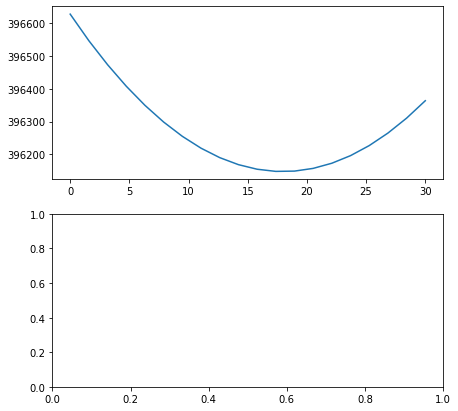

In [55]:
fig,  axes   = plt.subplots(nrows=2,ncols=1, figsize=(7, 7))
axes[0].plot(p_dc/1e3,p_loss)

In [17]:
sol

   direc: array([[   0.        ,    1.        ],
       [-935.21979958,  339.14541993]])
     fun: array(12282.76966481)
 message: 'Optimization terminated successfully.'
    nfev: 116
     nit: 3
  status: 0
 success: True
       x: array([20871.11509636, 23407.62236097])

In [21]:
gt_grid.dae2vi()

vsc_buses = ['R1','R10','R14']
a2n = {'a':1,'b':2,'c':3}
for vsc_bus in vsc_buses:
    for ph in ['a','b','c']:
        idx = list(gt_grid.nodes_list).index(f'{vsc_bus}.{a2n[ph]}') 
        gt_grid.I_node[idx] += grid.get_value(f'i_vsc_{vsc_bus}_{ph}_r')+1j*grid.get_value(f'i_vsc_{vsc_bus}_{ph}_i')

gt_grid.get_v()
gt_grid.get_i()

gt_grid.bokeh_tools()

gt.plot_results(gt_grid)

Figure(id='1145', ...)

In [39]:
from importlib import reload  



In [40]:
reload(ini)

TypeError: reload() argument must be a module

In [31]:
ini(grid_c3.struct,1)

In [148]:
@numba.njit(cache=True)
def ssate(struct,xy):
    for it in range(100):
        ini_dae_jacobian_numba(struct,xy[:,0])
        ini_dae_problem(struct,xy[:,0])
        xy[:] += np.linalg.solve(struct[0].Ac_ini,-struct[0].fg)
        if np.max(np.abs(struct[0].fg[:,0]))<1e-8: break
    N_x = struct[0].N_x
    struct[0].x[:,0] = xy[:N_x,0]
    struct[0].y_ini[:,0] = xy[N_x:,0]
    return xy,it